In [192]:
from __future__ import division

from collections import Counter, defaultdict
from itertools import product
import json
from math import sqrt
import time
import datetime

from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd

#scikit-learn
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import Birch
from sklearn import datasets

#h-stat
from sklearn_gbmi import *

#altair
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [53]:
#for reproducibility
np.random.seed(2019)
#functions to parse included datasets
def load_bike_dataset():
    def _datestr_to_timestamp(s):
        return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

    data = pd.read_csv('data/bike.csv')
    data['dteday'] = data['dteday'].apply(_datestr_to_timestamp)
    data = pd.get_dummies(data, prefix=["weathersit"], columns=["weathersit"], drop_first=False)

    features = ['season',\
                'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',\
                'weathersit_2', 'weathersit_3', 'weathersit_4',\
                'temp', 'atemp', 'hum', 'windspeed']
    
    features = ['yr', 'season', 'hr', 'workingday',
                'weathersit_2', 'weathersit_3', 'weathersit_4',
                'temp', 'atemp', 'hum', 'windspeed']    

    X = data[features]
    y = data['cnt']

    return X, y

def load_diabetes_dataset():
    diabetes_dataset = datasets.load_diabetes()

    return pd.DataFrame(diabetes_dataset.data, columns=diabetes_dataset.feature_names), diabetes_dataset.target  

def load_boston_dataset():
    boston_dataset = datasets.load_boston()

    return pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names), boston_dataset.target    

def load_dataset(name="bike"):
    
    if name =="bike":
        X,y = load_bike_dataset()
    elif name=="boston":
        X,y = load_boston_dataset() 
    elif name=="diabetes":
        X,y = load_diabetes_dataset()           
    gbm = GradientBoostingRegressor(min_samples_leaf=10, n_estimators=300)
    gbm.fit(X, y) 
    return X, y, gbm

In [4]:
#from original PyCEBox library
#get the x_values for a given granularity of curve
def _get_grid_points(x, num_grid_points):
    if sorted(list(x.unique())) == [0,1]:
        return [0.,1.]
    if num_grid_points is None:
        return x.unique()
    else:
        # unique is necessary, because if num_grid_points is too much larger
        # than x.shape[0], there will be duplicate quantiles (even with
        # interpolation)
        return x.quantile(np.linspace(0, 1, num_grid_points)).unique()

In [5]:
#from original PyCEBox library
#average the PDP lines (naive method seems to work fine)
def pdp(ice_data):
    return ice_data.mean(axis=0)

In [7]:
# from http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb
def _default_factory():
    return float("inf")

def _get_dtw_distance(s1,s2, w=4):
    
    w = max(w, abs(len(s1)-len(s2)))
    DTW = defaultdict(_default_factory)
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            DTW[(i, j)] = (s1[i]-s2[j])**2 + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            
    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [8]:
#transform curves before distance measurement
def _differentiate(series):
        
    dS = np.diff(series)
    return dS

In [9]:
#method for testing random clusters to ensure that algorithm performance is superior
def _test_random_clusters(ice_data, num_clusters=5):
    temp = np.random.uniform(size=num_clusters)
    distribution = temp/temp.sum()
    cluster_labels = np.random.choice(a = range(num_clusters),\
                                      size=ice_data.shape[0],\
                                      replace=False, p=distribution)
    return cluster_labels

In [10]:
#interpolate lines to num_grid_points when comparing features for feature-space statistics
def _interpolate_line(x, y, length):
    if len(y) == length:
        return y
    else:
        f = interp1d(x,y, kind="cubic")
        return list(f(np.linspace(x[0], x[-1], num=length, endpoint=True)))

# EVALUATION

In [11]:
def get_model_split(columns, model):
    split_feature = columns[model.tree_.feature[0]] if model.tree_.value.shape[0] > 1 else 'none'
    split_val = round(model.tree_.threshold[0],2)
    split_direction = "<=" if model.tree_.value.shape[0] == 1\
    or model.classes_[np.argmax(model.tree_.value[1])] == 1 else ">"
    return split_feature, split_val, split_direction

In [160]:
#main function - run this to export JSON file for vis
def export(data, y, predict_func, num_clusters=5, num_grid_points=40,\
           ice_curves_to_export=100, export_type="vis", cluster_method="birch"):
    
    export_dict = {"features":{}, "distributions":{}}
    
    #generate data for one ICE plot per column
    for column_of_interest in data.columns:

        ice_data = pd.DataFrame(np.ones(data.shape[0]), columns=["tempPlaceholderCol"])
    
        x_s = _get_grid_points(data[column_of_interest], num_grid_points)      
            
        #create dataframe with synthetic points (one for each x value returned by _get_grid_points)
        for x_val in x_s:
            kwargs = {column_of_interest : x_val}
            ice_data[x_val] = predict_func(data.assign(**kwargs))
        
        ice_data.drop("tempPlaceholderCol", axis=1, inplace=True)
        
        #center all curves at the mean11 point of the feature's range
        ice_data = ice_data.sub(ice_data.mean(axis=1), axis='index')

        pdp_data = pdp(ice_data)
        if export_type == "vis":
            hist_counts, hist_bins = np.histogram(a=np.array(data.loc[:,column_of_interest]), bins="auto")
            hist_zip = [{"x":x[0], "y":x[1]} for x in zip(hist_bins, hist_counts)]
            export_dict["distributions"][column_of_interest] = hist_zip
        export_dict["features"][column_of_interest] = {"feature_name": column_of_interest,
                                                       "x_values": list(x_s),
                                                       "pdp_line": list(pdp_data),
                                                       "importance": np.mean(pdp_data),
                                                       "clusters":[]
                                                      }
        if export_type == "analysis":
            export_dict["features"][column_of_interest]["ice_data"] = np.array(ice_data)       
        #perform clustering
        if cluster_method == "birch":
            ice_data["cluster_label"] = Birch(n_clusters = num_clusters, threshold=0.1)\
                        .fit(_differentiate(ice_data.values)).labels_
        elif cluster_method == "random":
            ice_data["cluster_label"] = _test_random_clusters(ice_data, num_clusters)
            
        
        ice_data["points"] = ice_data[x_s].values.tolist() 

        #generate all the ICE curves per cluster
        all_curves_by_cluster = ice_data.groupby("cluster_label")["points"].apply(lambda x: np.array(x)) 
        
        splits_first_pass = []
        for cluster_num in range(len(all_curves_by_cluster)):                          
            num_curves_in_cluster = len(all_curves_by_cluster[cluster_num])

            #build model to predict cluster membership
            rdwcY = ice_data["cluster_label"].apply(lambda x: 1 if x==cluster_num else 0)
            #1-node decision tree to get best split for each cluster
            model = DecisionTreeClassifier(criterion="entropy", max_depth=1, presort=False,\
                                           class_weight="balanced")
            model.fit(data, rdwcY)
            split_feature, split_val, split_direction = get_model_split(data.columns, model)
            splits_first_pass.append({"feature":split_feature, "val":split_val,\
                                      "direction": split_direction, "model": model})
       
        #loop through splits to find duplicates
        duplicate_splits = {}
        for i, split_def in enumerate(splits_first_pass[:-1]):
            for j, split_def_2 in enumerate(splits_first_pass):
                if j<=i or i in duplicate_splits or j in duplicate_splits:
                    continue
                elif split_def["feature"] == split_def_2["feature"]\
                and split_def["direction"] == split_def_2["direction"]\
                and (split_def["val"] - split_def_2["val"])/(np.ptp(data.loc[:,split_def["feature"]])) <= 0.1:
                    duplicate_splits[j] = i
        #and split_def["val"] == split_def_2["val"]:
        ice_data = ice_data.replace(to_replace={"cluster_label":duplicate_splits}, value=None)
        #generate all the ICE curves per cluster
        all_curves_by_cluster = ice_data.groupby("cluster_label")["points"].apply(lambda x: np.array(x)) 
        #average the above to get the mean cluster line
        cluster_average_curves = {key:np.mean(np.array(list(value)), axis=0)\
                                  for key,value in all_curves_by_cluster.iteritems()}
        
        for cluster_num in all_curves_by_cluster.keys():                          
            num_curves_in_cluster = len(all_curves_by_cluster[cluster_num])

            #build model to predict cluster membership
            rdwcY = ice_data["cluster_label"].apply(lambda x: 1 if x==cluster_num else 0)
            #1-node decision tree to get best split for each cluster
            '''
            model = DecisionTreeClassifier(criterion="entropy", max_depth=1, presort=False,\
                                           class_weight="balanced")
            model.fit(data, rdwcY)
            '''
            model = splits_first_pass[cluster_num]["model"]
            predY = model.predict(data) 
            split_feature, split_val, split_direction = get_model_split(data.columns, model)           
            
            #get random curves if there are more than 100
            #no reason to make the visualization display 1000+ curves for large datasets
            if num_curves_in_cluster > ice_curves_to_export:
                individual_ice_samples = [list(x) for x in\
                                          list(all_curves_by_cluster[cluster_num]\
                                          [np.random.choice(num_curves_in_cluster,\
                                                 size=ice_curves_to_export, replace=False)])
                                         ]
            else:
                individual_ice_samples = [list(x) for x in\
                                          list(all_curves_by_cluster[cluster_num])\
                                         ]
            
            #add cluster-level metrics to the JSON file
            if export_type == "vis":
                export_dict["features"][column_of_interest]["clusters"].append({
                    'accuracy': int(round(100.*metrics.accuracy_score(rdwcY, predY))),
                    'precision': int(round(100.*metrics.precision_score(rdwcY, predY))),
                    'recall': int(round(100.*metrics.recall_score(rdwcY, predY))),
                    'split_feature': split_feature,
                    'split_val': split_val,
                    'split_direction': split_direction,
                    'cluster_size': num_curves_in_cluster,
                    'line': list(cluster_average_curves[cluster_num]),
                    'individual_ice_curves': individual_ice_samples
                })
            else:
                export_dict["features"][column_of_interest]["clusters"].append({
                    'accuracy': int(round(100.*metrics.accuracy_score(rdwcY, predY))),
                    'precision': int(round(100.*metrics.precision_score(rdwcY, predY))),
                    'recall': int(round(100.*metrics.recall_score(rdwcY, predY))),
                    'split_feature': split_feature,
                    'split_val': split_val,
                    'split_direction': split_direction,                   
                    'predict_function': model.predict, 
                    'cluster_size': num_curves_in_cluster,
                    'line': list(cluster_average_curves[cluster_num])
                })                
        
        #feature-level calculation for cluster distance to pdp
        feature_val = export_dict["features"][column_of_interest]
        feature_val["cluster_deviation"]\
        = np.mean([_get_dtw_distance(np.array(feature_val["pdp_line"]),\
                                                  np.array(x["line"]))\
                  for x in feature_val["clusters"]])/np.mean(np.array(feature_val["pdp_line"]))
        if np.isnan(feature_val["cluster_deviation"]) or feature_val["cluster_deviation"]==float("inf"):
            feature_val["cluster_deviation"] = 0
        #EOF feature loop
        
    if export_type == "vis":
        with open('static/data.json', 'w') as outfile:
            json.dump(export_dict, outfile)   
    elif export_type == "analysis":
        return export_dict

In [183]:
def compare_to_h_statistic(data_frame, model_def, h_stats):
    h_stats_dict = {col:{} for col in data_frame.columns}
    for key in h_stats.iterkeys():
        h_stats_dict[key[0]][key[1]] = round(h_stats[key],3)
        h_stats_dict[key[1]][key[0]] = round(h_stats[key],3)
        
    def get_percent_interactors_in_top_3(feature):
        interactors = list([cluster["split_feature"] for cluster in model_def[feature]["clusters"]])
        if interactors[0] != "none":
            top_3 = [x[0] for x in sorted(h_stats_dict[feature].items(), key=lambda kv: kv[1], reverse=True)][:3]
            return sum([1 if x in top_3 else 0 for x in interactors]), len(interactors)
        else:
            return 0, len(interactors)
            
    sum_of_top_3 = 0.
    total_explanations = 0.
    baseline_rate = 3./len(data_frame.columns)
    for feature in data_frame.columns:
        top_3, num_explanations = get_percent_interactors_in_top_3(feature)
        sum_of_top_3 += top_3
        total_explanations += num_explanations
    
    return sum_of_top_3/total_explanations, baseline_rate
    

    '''
    if interactors[0] != "none":
        max_stat = np.max(np.array(h_stats_dict[feature].values()))
        print feature
        print interactors
        print sorted(h_stats_dict[feature].items(), key=lambda kv: kv[1], reverse=True)
        print [h_stats_dict[feature][interactor]/max_stat for interactor in interactors]
        print "\n"
    '''

In [148]:
def predict_ice(data_frame, model_def, offset):
    
    evaluation_set = np.array(data_frame)
    columns = data_frame.columns    
    
    def generate_interpolation_func(x, y):
        return interp1d(x,y, kind="linear")    
    
    funcs = np.array([[generate_interpolation_func(model_def[feature]["x_values"], model_def[feature]["ice_data"][row])\
                      for feature in columns] for row in range(dfX.shape[0])]).reshape(dfX.shape[0], dfX.shape[1])
    for row in range(funcs.shape[0]):
        for col in range(funcs.shape[1]):  
            evaluation_set[row,col] = funcs[row, col](evaluation_set[row,col])
    
    return evaluation_set.sum(axis=1) + offset

In [149]:
def predict_pdp(data_frame, model_def, offset):
    
    evaluation_set = np.array(data_frame)
    columns = data_frame.columns    
    
    def generate_interpolation_func(x, y):
        return interp1d(x,y, kind="linear")      
    
    funcs = [generate_interpolation_func(model_def[feature]["x_values"], model_def[feature]["pdp_line"])\
                      for feature in columns]
    #from https://stackoverflow.com/questions/52167120/numpy-fastest-way-to-apply-array-of-functions-to-matrix-columns
    for i,f in enumerate(funcs):
        evaluation_set[:,i] = f(evaluation_set[:,i])
    
    return evaluation_set.sum(axis=1) + offset

In [150]:
def predict_vine(data_frame, model_def, offset):
    
    evaluation_set = np.array(data_frame)
    columns = data_frame.columns

    def generate_interpolation_func(x, y):
        if x == [0.,1.]:
            def categorical_func(arr, y=y):
                return np.where(arr>0,y[1],y[0])
            return categorical_func
        else:
            return interp1d(x,y, kind="linear")    
    
    def generate_predicate(cluster_def, x_vals, pdp_line, pdp_only=False):
        
        if pdp_only or cluster_def["split_feature"] == "none":
            pdp_interpol = generate_interpolation_func(x_vals, pdp_line)
            def pdp_func(x, pdp_interpol=pdp_interpol):
                return np.full(x.shape[0],pdp_interpol)
            return pdp_func
        
        interpol = generate_interpolation_func(x_vals, cluster_def["line"])
        
        def output_func(x, predict_func=cluster_def["predict_function"], interpol=interpol):
            return np.where(predict_func(x) == 1, interpol, 0) 
        
        return output_func
    
    funcs = [[generate_predicate(cluster_def, model_def[feature]["x_values"],\
                                          model_def[feature]["pdp_line"])\
                       for cluster_def in\
                       sorted(model_def[feature]["clusters"], reverse=True, key=lambda x: x["cluster_size"])]\
             for feature in columns]
    for i_func, possible_split_funcs in enumerate(funcs):
        feature = columns[i_func]
        possible_split_funcs.append(generate_predicate(None, model_def[feature]["x_values"],\
                                          model_def[feature]["pdp_line"], True))
    
    results = np.zeros(shape=(evaluation_set.shape[0], evaluation_set.shape[1]))
    
    #from https://stackoverflow.com/questions/52167120/numpy-fastest-way-to-apply-array-of-functions-to-matrix-columns
    for i_func,possible_split_funcs in enumerate(funcs):
        temp = np.zeros(shape=(evaluation_set.shape[0], len(possible_split_funcs)), dtype=object)
        for i_inner, func in enumerate(possible_split_funcs):
            temp[:,i_inner] = func(evaluation_set)
        
        rows_handled = []
        func_outputs = []
        #from https://stackoverflow.com/questions/11731428/finding-first-non-zero-value-along-axis-of-a-sorted-two-dimensional-numpy-array
        for row, valid_func_id in zip(*np.where(temp != 0)):
            
            valid_func = temp[row, valid_func_id]
            
            if row in rows_handled:
                func_outputs[row].append(valid_func(evaluation_set[row,i_func])[()])
            else:
                rows_handled.append(row)
                func_outputs.append([valid_func(evaluation_set[row,i_func])[()]])
                
        results[:,i_func] = np.array([(sum(x[:-1] if len(x)>1 else x))/max(len(x[:-1]),1) for x in func_outputs])

    return results.sum(axis=1) + offset

In [151]:
def get_prediction_scores(y, predictions, offset):
    return {"R-Squared": metrics.r2_score(y, predictions),
            "MSE":  (metrics.mean_squared_error(y, predictions)**.5)/offset
           }

In [ ]:


feature_list = [l[0] for l in [[add_keys_to_cluster(c, {"feature_name":key, "cluster_num":i})\
  for i,c in enumerate([v for v in value["clusters"]])]\
 for key, value in export_dict["features"].items()] for l[0] in l]

feature_df = pd.DataFrame(feature_list).loc[:,
                                            ["feature_name", "cluster_num", "accuracy", "cluster_size", 
                                             "precision", "recall", "confusion_matrix",\
                                            "split_feature", "split_val", "split_direction"]]
feature_df["id"] = feature_df.apply(lambda x: x["feature_name"]+": "\
                                                +x["split_feature"]+x["split_direction"]+str(x["split_val"]),axis=1)

#one split
print "mean accuracy: " + str(np.mean(feature_df["accuracy"]))
print "mean precision: " + str(np.mean(feature_df["precision"]))
print "mean recall: " + str(np.mean(feature_df["recall"]))

In [157]:
def add_keys_to_cluster(cluster, new_vals):
    z = cluster.copy()
    z.update(new_vals)
    return z

In [195]:
# GENERATE RESULT DATA FOR CHARTS
results = {}
for dataset in ["diabetes", "boston"]:
    print dataset
    results[dataset] = {}
    dfX, y, predictor = load_dataset(name=dataset)
    VINE_data = export(dfX, y, predictor.predict,
                       num_clusters=5,
                       num_grid_points=20,
                       export_type="analysis",
                       cluster_method="birch"
                      )
    VINE_data_random = export(dfX, y, predictor.predict,
                       num_clusters=5,
                       num_grid_points=20,
                       export_type="analysis",
                       cluster_method="random"
                      )
    #basic dataset statistics
    results[dataset]["model_r2_score"] = metrics.r2_score(y, predictor.predict(dfX))   
    results[dataset]["dataset_instances"] = dfX.shape[0]
    results[dataset]["dataset_features"] = dfX.shape[1]
    #H-statistic score
    raw_h_stats = h_all_pairs(predictor, dfX)
    h_stat_score, h_stat_baseline = compare_to_h_statistic(dfX, VINE_data["features"], raw_h_stats)
    results[dataset]["h_stat_score"] = h_stat_score
    results[dataset]["h_stat_baseline"] = h_stat_baseline
    
    #Explanation accuracy metrics
    feature_df = pd.DataFrame([l[0] for l in [[add_keys_to_cluster(c, {"feature_name":key, "cluster_num":i})\
      for i,c in enumerate([v for v in value["clusters"]])]\
     for key, value in VINE_data["features"].items()] for l[0] in l])
    feature_df_random = pd.DataFrame([l[0] for l in [[add_keys_to_cluster(c, {"feature_name":key, "cluster_num":i})\
      for i,c in enumerate([v for v in value["clusters"]])]\
     for key, value in VINE_data_random["features"].items()] for l[0] in l])    
    
    results[dataset]["scores"] = {}
    for metric in ["accuracy", "precision", "recall"]:
        results[dataset]["scores"][metric] = {}
        results[dataset]["scores"][metric]["explanation"] = np.mean(feature_df[metric])
        results[dataset]["scores"][metric]["random"] = np.mean(feature_df_random[metric])
        
    #ICE,PDP, and VINE Information Ceiling scores
    offset = y.mean()
    #ICE
    results[dataset]["ice_score"] = get_prediction_scores(y, 
                                                          predict_ice(dfX, VINE_data["features"], offset),
                                                          offset)
    #PDP
    results[dataset]["pdp_score"] = get_prediction_scores(y, 
                                                          predict_pdp(dfX, VINE_data["features"], offset),
                                                          offset)  
    #Run VINE for each cluster size
    results[dataset]["vine_score"] = {}
    for c in range(3,8):
        VINE_data_loop = export(dfX, y, predictor.predict,
                           num_clusters=c,
                           num_grid_points=20,
                           export_type="analysis",
                           cluster_method="birch"
                          ) 
        results[dataset]["vine_score"][c] = get_prediction_scores(y, 
                                                          predict_vine(dfX, VINE_data_loop["features"], offset),
                                                          offset) 

diabetes


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in double_scalars


boston


In [196]:
results

{'boston': {'dataset_features': 13,
  'dataset_instances': 506,
  'h_stat_baseline': 0.23076923076923078,
  'h_stat_score': 0.6415094339622641,
  'ice_score': {'MSE': 0.17903250805244558, 'R-Squared': 0.8072247413072631},
  'model_r2_score': 0.9869244561467252,
  'pdp_score': {'MSE': 0.1789334542918607, 'R-Squared': 0.8074379967895018},
  'scores': {'accuracy': {'explanation': 85.9622641509434,
    'random': 45.111111111111114},
   'precision': {'explanation': 66.37735849056604,
    'random': 31.873015873015873},
   'recall': {'explanation': 91.13207547169812, 'random': 70.52380952380952}},
  'vine_score': {3: {'MSE': 0.15568392855408802,
    'R-Squared': 0.8542276794323254},
   4: {'MSE': 0.14849175159513278, 'R-Squared': 0.8673851484306854},
   5: {'MSE': 0.15934611011540342, 'R-Squared': 0.8472889597722737},
   6: {'MSE': 0.1545645362296278, 'R-Squared': 0.8563163957952316},
   7: {'MSE': 0.1535158499201172, 'R-Squared': 0.8582595047424113}}},
 'diabetes': {'dataset_features': 10,
 

# Charts

In [262]:
explanation_accuracy = []
for dataset, result in results.iteritems():
    for score_type, score in result["scores"].iteritems():
        explanation_accuracy.append({
            "Dataset":dataset,
            "Metric":score_type,
            "Condition": "Cluster Explanation",
            "Score": score["explanation"]
        })
        explanation_accuracy.append({
            "Dataset":dataset,
            "Metric":score_type,
            "Condition": "Random Baseline",
            "Score": score["random"]
        })        
        
explanation_accuracy_df = pd.DataFrame(explanation_accuracy)

In [267]:
information_ceiling = []
for dataset, result in results.iteritems():
    for i in range(3,8):
        information_ceiling.append({
            "Dataset":dataset,
            "Number of Clusters": i,
            "Visualization": "PDP",
            "R2": result["pdp_score"]["R-Squared"]
        })
        information_ceiling.append({
            "Dataset":dataset,
            "Number of Clusters": i,
            "Visualization": "ICE",
            "R2": result["ice_score"]["R-Squared"]
        })
    for key, val in result["vine_score"].iteritems():
        information_ceiling.append({
            "Dataset":dataset,
            "Number of Clusters": key,
            "Visualization": "VINE",
            "R2": val["R-Squared"]
        })    
information_ceiling_df = pd.DataFrame(information_ceiling)        

In [ ]:
base = alt.Chart(explanation_accuracy_df)

bar = base.mark_bar().encode(
    x='score_type:O',
    y='expl_score:Q',
    column='dataset:N'
)

tick = base.mark_tick(
    color='red',
    thickness=2
).encode(
    x='score_type:O',
    y='rand_score:Q',
    column='dataset:N'
)

(bar + tick).configure_tick(
    bandSize=35  # controls the width of the tick
).configure_scale(
    rangeStep=40  # controls the width of the bar
)

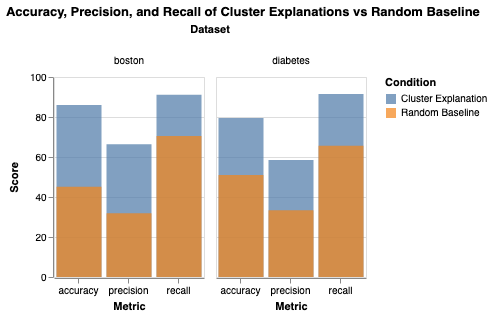

In [264]:
alt.Chart(explanation_accuracy_df).mark_bar(opacity=0.7).encode(
    x='Metric:O',
    y=alt.Y('Score:Q', stack=None),
    column='Dataset:N',
    color="Condition:N"
).properties(
    title="Accuracy, Precision, and Recall of Cluster Explanations vs Random Baseline",
    height=200, 
    width=150
).configure_axisBottom(labelAngle=0)

In [ ]:
alt.Chart(feature_df).mark_circle(size=100).encode(
    x='feature_name',
    y={
        "field": "cluster_size", 
        "type": "quantitative",
        "scale": {"type": "log", "exponent":0.5}
    },
    color=alt.Color(field="id", type="nominal", legend=None, scale=alt.Scale(scheme = "blues-3")),
    order=alt.Order('cluster_size', sort='descending')
).properties(
    title="Cluster Sizes by Feature",
    height=400, 
    width=700
)

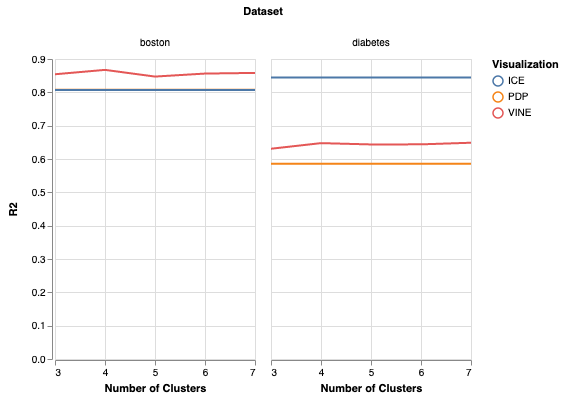

In [284]:
'''    title="Information Ceiling of PDP, ICE, and VINE plots by dataset",'''

alt.Chart(information_ceiling_df).mark_line().encode(
    x="Number of Clusters",
    y="R2",
    color="Visualization"
).properties(
    height=300, 
    width=200
).facet(column="Dataset")